In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Multi-label Classifier
Mapping visual feature to high-level movie tags

##Load Training Dataset

In [ ]:
import h5py
import numpy as np
import os
import tensorflow as tf
def dataset(feature_path,annotation_path):
  x = []
  y = []
  title = os.listdir(annotation_path)
  for t in title:
    x_path = os.path.join(feature_path,t)
    x_feature = np.loadtxt(x_path)
    x.append(x_feature)
    y_path = os.path.join(annotation_path,t)
    y_label = np.loadtxt(y_path)
    y.append(y_label)
  x = tf.convert_to_tensor(x, dtype=tf.float32)
  y = tf.convert_to_tensor(y, dtype=tf.float32)
  return x,y

def save_dataset(x,y,data_path):
  x_path = os.path.join(data_path, 'trainingdata_x.hdf5')
  y_path = os.path.join(data_path, 'trainingdata_y.hdf5')
  with h5py.File(x_path, 'w') as f1:
    dset1 = f1.create_dataset("x", data=x,dtype='float32')
  f1.close()
  with h5py.File(y_path, 'w') as f2:
    dset2 = f2.create_dataset("y", data=y,dtype='float32')
  f2.close()

def load_data_from_h5py(data_path):
  x_path = os.path.join(data_path, 'trainingdata_x.hdf5')
  y_path = os.path.join(data_path, 'trainingdata_y.hdf5')
  f1 = h5py.File(x_path,'r')
  x = np.array(f1["x"][:])
  f2 = h5py.File(y_path,'r')
  y = np.array(f2["y"][:])
  x = tf.convert_to_tensor(x, dtype=tf.float32)
  y = tf.convert_to_tensor(y, dtype=tf.float32)
  return x,y

In [ ]:
#x, y = dataset(feature_path,annotation_path)
data_path = '../model/CNN-based_Visual_Model/Training_Dataset/6K_pre-training_dataset(genre)'
#save_dataset(x,y,data_path)
train_x, train_y = load_data_from_h5py(data_path)
print(train_x.shape)
print(train_y.shape)

(6067, 25088)
(6067, 19)


##Class Weights

In [ ]:
import pandas as pd

y_np = np.array(train_y)
df_y = pd.DataFrame(y_np,columns=['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Fantasy','History','Horror','Western','Thriller','ScienceFiction','Family','Music','Mystery','Romance','TVMovie','War'])
df_y

Action  Adventure  Animation  Comedy  ...  Mystery  Romance  TVMovie  War
0        0.0        0.0        0.0     0.0  ...      0.0      0.0      0.0  0.0
1        0.0        0.0        0.0     0.0  ...      0.0      0.0      0.0  0.0
2        0.0        0.0        0.0     1.0  ...      0.0      0.0      0.0  0.0
3        0.0        1.0        0.0     1.0  ...      0.0      0.0      0.0  0.0
4        1.0        0.0        1.0     1.0  ...      0.0      0.0      0.0  0.0
...      ...        ...        ...     ...  ...      ...      ...      ...  ...
6062     0.0        1.0        1.0     0.0  ...      0.0      0.0      0.0  0.0
6063     0.0        0.0        1.0     0.0  ...      0.0      1.0      0.0  0.0
6064     0.0        0.0        0.0     1.0  ...      0.0      1.0      0.0  0.0
6065     0.0        0.0        0.0     1.0  ...      0.0      1.0      0.0  0.0
6066     1.0        1.0        0.0     1.0  ...      0.0      0.0      0.0  0.0

[6067 rows x 19 columns]

In [ ]:
df_y.sum()

Action            1177.0
Adventure          664.0
Animation          474.0
Comedy            1736.0
Crime              638.0
Documentary        383.0
Drama             2753.0
Fantasy            491.0
History            289.0
Horror             946.0
Western             50.0
Thriller          1506.0
ScienceFiction     587.0
Family             470.0
Music              203.0
Mystery            464.0
Romance            735.0
TVMovie            146.0
War                165.0
dtype: float32

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
#print(compute_class_weight(np.unique(y_org)))
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
#weight_for_0 = (1 / neg)*(total)/2.0 
#weight_for_1 = (1 / pos)*(total)/2.0
y_org = np.array(train_y)
n_class = y_org.shape[1]
class_weights = np.zeros((n_class,2))
class_weights = {}
for i in range(n_class):
        weights = []
        weights_n, weights_p = (y_org.shape[0]/(2 * (y_org[:,i] == 0).sum())), (y_org.shape[0]/(2 * (y_org[:,i] == 1).sum()))
        class_weights[i] = weights_p

print(class_weights)

{0: 2.5773152081563295, 1: 4.568524096385542, 2: 6.399789029535865, 3: 1.7474078341013826, 4: 4.754702194357367, 5: 7.920365535248042, 6: 1.1018888485288776, 7: 6.178207739307536, 8: 10.496539792387543, 9: 3.206659619450317, 10: 60.67, 11: 2.014276228419655, 12: 5.1678023850085175, 13: 6.4542553191489365, 14: 14.943349753694582, 15: 6.537715517241379, 16: 4.127210884353741, 17: 20.777397260273972, 18: 18.384848484848487}


##Models

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [ ]:
classifier_D = Sequential(name='classifier_A')
classifier_D.add(Input(shape=(25088,)))
classifier_D.add(Dense(1024,activation='relu'))
classifier_D.add(Dropout(0.5))
classifier_D.add(Dense(19,activation='sigmoid'))
classifier_D.summary()

In [ ]:
classifier_A = Sequential(name='classifier_A')
classifier_A.add(Input(shape=(25088,)))
classifier_A.add(Dense(4096,activation='relu'))
classifier_A.add(Dropout(0.5))
classifier_A.add(Dense(19,activation='sigmoid'))
classifier_A.summary()

In [ ]:
classifier_B = Sequential(name='classifier_B')
classifier_B.add(Input(shape=(25088,)))
classifier_B.add(Dense(4096,activation='relu'))
classifier_B.add(Dropout(0.5))
classifier_B.add(Dense(4096,activation='relu'))
classifier_B.add(Dropout(0.5))
classifier_B.add(Dense(19,activation='sigmoid'))
classifier_B.summary()

In [ ]:
classifier_C = Sequential(name='classifier_c')
classifier_C.add(Input(shape=(25088,)))
classifier_C.add(Dense(4096,activation='relu'))
classifier_C.add(Dropout(0.5))
classifier_C.add(Dense(4096,activation='relu'))
classifier_C.add(Dropout(0.5))
classifier_C.add(Dense(1024,activation='relu'))
classifier_C.add(Dropout(0.5))
classifier_C.add(Dense(19,activation='sigmoid'))
classifier_C.summary()

In [ ]:
#tf.keras.utils.plot_model(classifier_C, to_file='model.png', show_shapes=True, show_layer_names=True)

##Training Details

###Classifier_A

In [ ]:
METRICS = [
           keras.metrics.TruePositives(name='tp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.CategoricalAccuracy(name='cate_accuracy')
]

# Callback model
#checkpoint_filepath = 'weights.{epoch:02d}-{accuracy:.2f}.hdf5'
#checkpoint = ModelCheckpoint(filepath= checkpoint_filepath, save_weights_only= False, monitor='accuracy', verbose=1, save_best_only=True, mode='auto')
# Compile model
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
classifier_A.compile(loss='binary_crossentropy', optimizer= adam, metrics=METRICS)
#
result_A = classifier_A.fit(train_x, train_y, batch_size=128, epochs=100, verbose=1, validation_split=0.3, class_weight=class_weights) #, callbacks= [checkpoint])

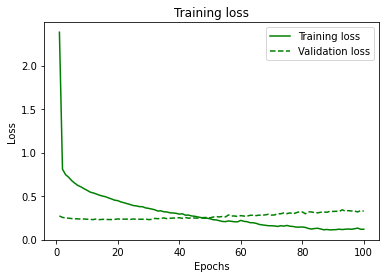

In [ ]:
loss_A = result_A.history['loss']
epochs_A = range(1, len(loss_A) + 1)
plt.plot(epochs_A, loss_A, 'g', label='Training loss')


val_loss_A = result_A.history['val_loss']
plt.plot(epochs_A, val_loss_A, 'g--', label='Validation loss')


plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

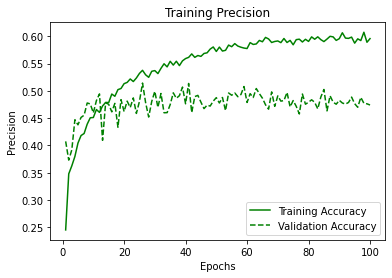

In [ ]:
acc_A = result_A.history['cate_accuracy']
epochs_A = range(1, len(acc_A) + 1)
plt.plot(epochs_A, acc_A, 'g', label='Training Accuracy')

val_acc_A = result_A.history['val_cate_accuracy']
plt.plot(epochs_A, val_acc_A, 'g--', label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training Precision')
plt.legend()
plt.show()

###Classifier_B

In [ ]:
METRICS = [
           keras.metrics.TruePositives(name='tp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='bi_accuracy'),
           keras.metrics.CategoricalAccuracy(name='cate_accuracy')
]
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
classifier_B.compile(loss='binary_crossentropy', optimizer= adam, metrics=METRICS)

result_B = classifier_B.fit(train_x, train_y, batch_size=128, epochs=100, verbose=1, validation_split=0.3,class_weight=class_weights) #, callbacks= [checkpoint])

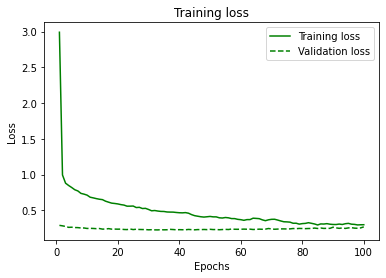

In [ ]:
loss_B = result_B.history['loss']
epochs_B = range(1, len(loss_B) + 1)
plt.plot(epochs_B, loss_B, 'g', label='Training loss')

val_loss_B = result_B.history['val_loss']
plt.plot(epochs_B, val_loss_B, 'g--', label='Validation loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

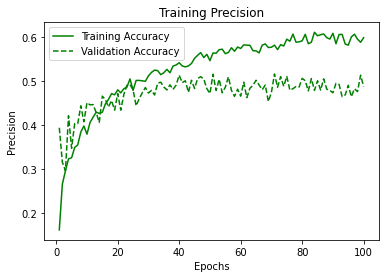

In [ ]:
acc_B = result_B.history['cate_accuracy']
epochs_B = range(1, len(acc_B) + 1)
plt.plot(epochs_B, acc_B, 'g', label='Training Accuracy')

val_acc_B = result_B.history['val_cate_accuracy']
plt.plot(epochs_B, val_acc_B, 'g--', label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training Precision')
plt.legend()
plt.show()

###Classifier_C

In [ ]:
METRICS = [
           keras.metrics.TruePositives(name='tp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='bi_accuracy'),
           keras.metrics.CategoricalAccuracy(name='cate_accuracy')
]
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
classifier_C.compile(loss='binary_crossentropy', optimizer= adam, metrics=METRICS)

result_C = classifier_C.fit(train_x, train_y, batch_size=128, epochs=100, verbose=1, validation_split=0.3, class_weight=class_weights) #, callbacks= [checkpoint])

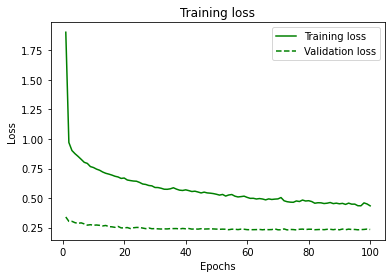

In [ ]:
loss_C = result_C.history['loss']
epochs_C = range(1, len(loss_C) + 1)
plt.plot(epochs_C, loss_C, 'g', label='Training loss')


val_loss_C = result_C.history['val_loss']
plt.plot(epochs_C, val_loss_C, 'g--', label='Validation loss')


plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

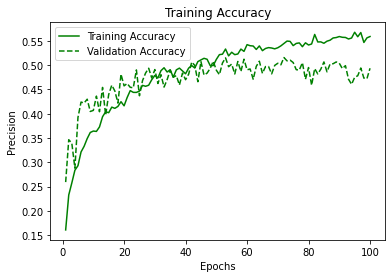

In [ ]:
acc_C = result_C.history['cate_accuracy']
epochs_C = range(1, len(acc_C) + 1)
plt.plot(epochs_C, acc_C, 'g', label='Training Accuracy')

val_acc_C = result_C.history['val_cate_accuracy']
plt.plot(epochs_C, val_acc_C, 'g--', label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [ ]:
METRICS = [
           keras.metrics.TruePositives(name='tp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='bi_accuracy'),
           keras.metrics.CategoricalAccuracy(name='cate_accuracy')
]
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
classifier_D.compile(loss='binary_crossentropy', optimizer= adam, metrics=METRICS)

result_D = classifier_D.fit(train_x, train_y, batch_size=128, epochs=100, verbose=1, validation_split=0.3, class_weight=class_weights) #, callbacks= [checkpoint])

###Comparison

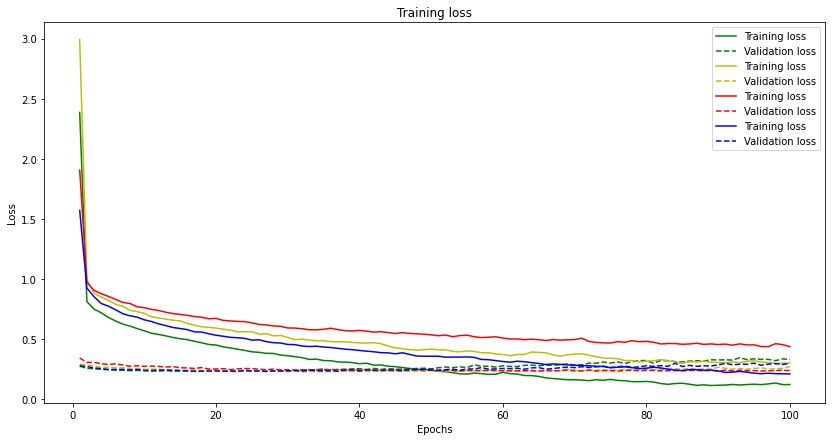

In [ ]:
plt.figure(figsize=(14,7))
loss_A = result_A.history['loss']
epochs_A = range(1, len(loss_A) + 1)
plt.plot(epochs_A, loss_A, 'g', label='Training loss')


val_loss_A = result_A.history['val_loss']
plt.plot(epochs_A, val_loss_A, 'g--', label='Validation loss')


loss_B = result_B.history['loss']
epochs_B = range(1, len(loss_B) + 1)
plt.plot(epochs_B, loss_B, 'y', label='Training loss')

val_loss_B = result_B.history['val_loss']
plt.plot(epochs_B, val_loss_B, 'y--', label='Validation loss')



loss_C = result_C.history['loss']
epochs_C = range(1, len(loss_C) + 1)
plt.plot(epochs_C, loss_C, 'r', label='Training loss')


val_loss_C = result_C.history['val_loss']
plt.plot(epochs_C, val_loss_C, 'r--', label='Validation loss')


loss_D = result_D.history['loss']
epochs_D = range(1, len(loss_D) + 1)
plt.plot(epochs_D, loss_D, 'b', label='Training loss')


val_loss_D = result_D.history['val_loss']
plt.plot(epochs_D, val_loss_D, 'b--', label='Validation loss')


plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

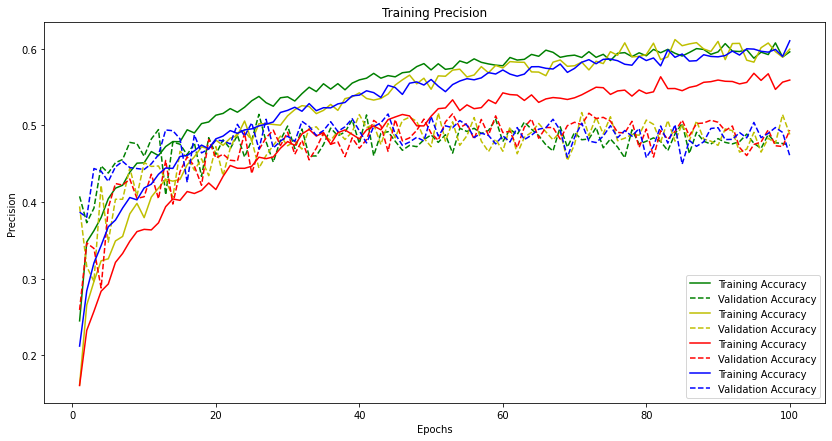

In [ ]:
plt.figure(figsize=(14,7))
acc_A = result_A.history['cate_accuracy']
epochs_A = range(1, len(acc_A) + 1)
plt.plot(epochs_A, acc_A, 'g', label='Training Accuracy')

val_acc_A = result_A.history['val_cate_accuracy']
plt.plot(epochs_A, val_acc_A, 'g--', label='Validation Accuracy')

acc_B = result_B.history['cate_accuracy']
epochs_B = range(1, len(acc_B) + 1)
plt.plot(epochs_B, acc_B, 'y', label='Training Accuracy')

val_acc_B = result_B.history['val_cate_accuracy']
plt.plot(epochs_B, val_acc_B, 'y--', label='Validation Accuracy')

acc_C = result_C.history['cate_accuracy']
epochs_C = range(1, len(acc_C) + 1)
plt.plot(epochs_C, acc_C, 'r', label='Training Accuracy')

val_acc_C = result_C.history['val_cate_accuracy']
plt.plot(epochs_C, val_acc_C, 'r--', label='Validation Accuracy')

acc_D = result_D.history['cate_accuracy']
epochs_D = range(1, len(acc_D) + 1)
plt.plot(epochs_D, acc_D, 'b', label='Training Accuracy')

val_acc_D = result_D.history['val_cate_accuracy']
plt.plot(epochs_D, val_acc_D, 'b--', label='Validation Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training Precision')
plt.legend()
plt.show()

###Training result Visualization

In [ ]:
plt.figure(figsize=(14,8))
pre_A = result_A.history['precision']
epochs_A = range(1, len(pre_A) + 1)
plt.plot(epochs_A, pre_A, 'r', label='Classifier-A')

recall_A = result_A.history['recall']
epochs_A = range(1, len(recall_A) + 1)
plt.plot(epochs_A, recall_A, 'r--', label='Classifier-A')

#plt.plot(epochs, top_k_acc_A, 'r--', label='Top5 Accuracy')

##top_k_acc_B = result_B.history['top_k_categorical_accuracy']
##acc_B = result_B.history['accuracy']
###plt.plot(epochs, top_k_acc_B, 'y--', label='Top5 Accuracy')
##plt.plot(epochs, acc_B, 'y', label='Training Accuracy')

#top_k_acc_C = result_C.history['top_k_categorical_accuracy']
#acc_C = result_C.history['accuracy']
#epochs_C = range(1, len(acc_C) + 1)
#plt.plot(epochs, top_k_acc_C, 'g--', label='Top5 Accuracy')
#plt.plot(epochs_C, acc_C, 'g', label='Training Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training Precision')
plt.legend()
plt.show()

In [ ]:
loss_A = result_A.history['loss']
epochs_A = range(1, len(loss_A) + 1)
plt.plot(epochs_A, loss_A, 'r', label='Training loss')
#
loss_B = result_B.history['loss']
epochs_B = range(1, len(loss_B) + 1)
plt.plot(epochs_B, loss_B, 'y', label='Training loss')

loss_C = result_C.history['loss']
epochs_C = range(1, len(loss_C) + 1)
plt.plot(epochs_C, loss_C, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#save model
classifier.save('../model/CNN-based_Visual_Model/Model_Weight/6K_genre_classifier')

##Evaluation

In [ ]:
#load saved model
filepath = '../model/CNN-based_Visual_Model/Model_Weight/6K_genre_classifier'
model = load_model(filepath)
# evaluate the model
scores = model.evaluate(x, y, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


48/48 [==============================] - 1s 14ms/step - loss: 0.1831 - accuracy: 0.6534
loss: 18.31%
accuracy: 65.34%


##Test Example

In [ ]:
Genres = ['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Fantasy','History','Horror','Western','Thriller','ScienceFiction','Family','Music','Mystery','Romance','TVMovie','War']

def test(path):
  x = np.loadtxt(path)
  #x = np.expand_dims(x,axis=0)
  x = tf.convert_to_tensor(x,dtype=tf.float32)
  proba = model.predict(x)
  out_path = path.replace('feature','predict')
  np.savetxt(out_path,proba)
  return proba

def proba_anay(proba):
  proba = np.mean(proba,axis=0)
  print(proba.shape)
  sorted_categories = np.argsort(proba)[:-7:-1]
  print(sorted_categories)
  for i in range(6):
    print('{}'.format(Genres[sorted_categories[i]]) + '({:.3})'.format(proba[sorted_categories[i]]))
  print('\n')

In [ ]:
test_path = '../data/86_movie/8_movie/8_movie_25088feature'
f = os.listdir(test_path)
for i in f:
  print(i)
  path = os.path.join(test_path,i)
  p = test(path)
  print(p.shape)
  proba_anay(p)

AliceInWonderland_En.txt
(5000, 19)
(19,)
[3 1 6 0 9 7]
Comedy(0.375)
Adventure(0.324)
Drama(0.269)
Action(0.238)
Horror(0.209)
Fantasy(0.202)


Sherlock_Holmes_t01_En.txt
(4126, 19)
(19,)
[ 6  0  3 11  9 12]
Drama(0.414)
Action(0.267)
Comedy(0.246)
Thriller(0.224)
Horror(0.218)
ScienceFiction(0.151)


Streetdance_Eu.txt
(6344, 19)
(19,)
[ 3  6  0 16  5  1]
Comedy(0.36)
Drama(0.352)
Action(0.218)
Romance(0.174)
Documentary(0.164)
Adventure(0.144)


Amelie.txt
(3860, 19)
(19,)
[ 6  3  9  0 11 16]
Drama(0.352)
Comedy(0.333)
Horror(0.217)
Action(0.211)
Thriller(0.184)
Romance(0.163)




In [ ]:
p = np.loadtxt('../data/86_movie/8_movie/8_movie_predict_genre/Amelie.txt')

In [ ]:
p.shape

(3860, 19)

In [ ]:
def proba_anay(proba):
  proba = np.mean(proba,axis=0)
  print(proba.shape)
  sorted_categories = np.argsort(proba)[:-7:-1]
  print(sorted_categories)
  for i in range(6):
    print('{}'.format(Genres[sorted_categories[i]]) + '({:.3})'.format(proba[sorted_categories[i]]))
  print('\n')
  return sorted_categories

In [ ]:
genres = proba_anay(p)

(19,)
[ 6  3  9  0 11 16]
Drama(0.352)
Comedy(0.333)
Horror(0.217)
Action(0.211)
Thriller(0.184)
Romance(0.163)




In [ ]:
import zipfile
with zipfile.ZipFile('../data/86_movie/8_movie/8_movie_keyframe.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')

In [ ]:
file_path = '/content/Data/movie_keyframe/Amelie'
f = os.listdir(file_path)
f = sorted(f)
print(f)

['shot_0000_img_1.jpg', 'shot_0001_img_1.jpg', 'shot_0002_img_1.jpg', 'shot_0002_img_2.jpg', 'shot_0003_img_0.jpg', 'shot_0003_img_1.jpg', 'shot_0003_img_2.jpg', 'shot_0004_img_1.jpg', 'shot_0005_img_1.jpg', 'shot_0005_img_2.jpg', 'shot_0006_img_0.jpg', 'shot_0006_img_1.jpg', 'shot_0006_img_2.jpg', 'shot_0007_img_0.jpg', 'shot_0007_img_1.jpg', 'shot_0007_img_2.jpg', 'shot_0008_img_0.jpg', 'shot_0008_img_1.jpg', 'shot_0008_img_2.jpg', 'shot_0009_img_0.jpg', 'shot_0009_img_1.jpg', 'shot_0009_img_2.jpg', 'shot_0010_img_0.jpg', 'shot_0010_img_1.jpg', 'shot_0010_img_2.jpg', 'shot_0011_img_0.jpg', 'shot_0011_img_1.jpg', 'shot_0011_img_2.jpg', 'shot_0012_img_0.jpg', 'shot_0012_img_1.jpg', 'shot_0012_img_2.jpg', 'shot_0013_img_0.jpg', 'shot_0013_img_1.jpg', 'shot_0013_img_2.jpg', 'shot_0014_img_0.jpg', 'shot_0014_img_1.jpg', 'shot_0014_img_2.jpg', 'shot_0015_img_0.jpg', 'shot_0015_img_1.jpg', 'shot_0015_img_2.jpg', 'shot_0016_img_0.jpg', 'shot_0016_img_1.jpg', 'shot_0016_img_2.jpg', 'shot_0017

In [ ]:
keyf = sorted(di[16])
img = []
for k in keyf:
  img.append(f[k])
print(img)

['shot_0067_img_1.jpg', 'shot_0067_img_2.jpg', 'shot_0278_img_2.jpg', 'shot_0355_img_0.jpg', 'shot_0473_img_0.jpg', 'shot_0566_img_1.jpg', 'shot_0567_img_1.jpg', 'shot_0575_img_0.jpg', 'shot_0575_img_1.jpg', 'shot_0585_img_1.jpg', 'shot_0711_img_1.jpg', 'shot_1136_img_1.jpg', 'shot_1136_img_2.jpg', 'shot_1197_img_2.jpg', 'shot_1207_img_2.jpg', 'shot_1208_img_2.jpg', 'shot_1225_img_2.jpg', 'shot_1230_img_0.jpg']


In [ ]:
from keras.preprocessing.image import load_img
def show_image(image_name):
  image_path = os.path.join(file_path,image_name)
  image = load_img(image_path)
  plt.imshow(image)

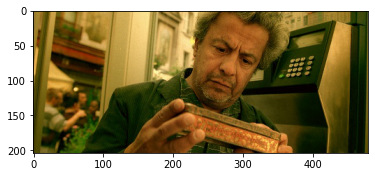

In [ ]:
show_image(f[1276])